In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [103]:
GOOGLE_ANALYTICS_START_DATE = datetime.date(2019,9,13)

df = pd.read_csv(
        '../data/blogs_with_analytics.csv', 
        sep='\t', 
        parse_dates=['time'],
        date_parser=lambda col: pd.to_datetime(col))
df = df[df['time'] >= pd.Timestamp(GOOGLE_ANALYTICS_START_DATE)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 654
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    266 non-null    int64         
 1   url                      266 non-null    object        
 2   title                    266 non-null    object        
 3   time                     266 non-null    datetime64[ns]
 4   category                 266 non-null    object        
 5   description              265 non-null    object        
 6   text                     266 non-null    object        
 7   introduction             266 non-null    object        
 8   author                   266 non-null    object        
 9   author_job_title         266 non-null    object        
 10  pageviews                266 non-null    int64         
 11  unique_pageviews         266 non-null    int64         
 12  avg_time                 266 non-nul

# Correlation matrix

In [104]:
import seaborn as sns
corr_matrix = df.corr()
performance_features = ['pageviews', 'avg_time', 'bounce_rate', 'exit%']
predictors = sorted(list(set(df.select_dtypes(include=['float64', 'int64']).columns) - set(performance_features) - set(['index', 'unique_pageviews'])))
corr_matrix = corr_matrix.loc[predictors, performance_features]
corr_matrix.style.background_gradient(cmap='RdBu_r')

,pageviews,avg_time,bounce_rate,exit%
average_sentence_length,-0.098934,-0.115445,-0.112582,-0.203577
average_stopword,-0.036407,0.094998,-0.102926,-0.020227
dale_chall,-0.029664,-0.239072,0.180872,-0.006347
flesch,-0.052520,-0.027496,-0.110552,-0.085769
mmr_lift,-0.004990,-0.044294,0.015530,0.017781
semantic compound score,0.005168,-0.062172,-0.003000,-0.056317
semantic neg score,-0.000345,0.230704,-0.020438,0.153309
semantic neu score,0.064763,0.072105,0.239363,0.279451
semantic pos score,-0.067805,-0.172538,-0.238654,-0.354251
text_length,0.183283,0.386777,0.115781,0.301340


# Feature importance with linear regression

## Lasso coefficients

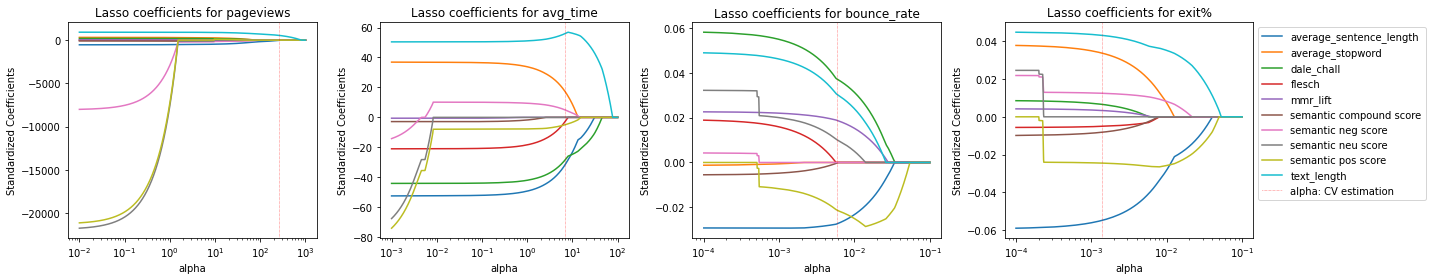

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

alpha_log_limits = [(-2,3),(-3,2),(-4,-1),(-4,-1)]
lasso = Lasso(max_iter=10000)
opt_models = []
fig = plt.figure(figsize=(20,4))
for i, target_feature in enumerate(performance_features):
    alphas = np.logspace(*alpha_log_limits[i], 1000)
    X = df[predictors]
    y = df[target_feature]
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    # Normalize predictors
    scaler = StandardScaler().fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Train a Lasso predictor for each alpha
    coefs = []
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)
    # Train an optimal Lasso predictor using CV
    model = LassoCV(cv=5, random_state=0, max_iter=10000, eps=1e-4)
    model.fit(X_train, y_train)
    opt_models.append(model)
    opt_alpha = model.alpha_
    # Plot the coefficients over alpha
    ax = plt.subplot(1,4,i+1)
    ax.plot(alphas, coefs, label=predictors)
    ax.axvline(x=opt_alpha, color='r', ls=':', lw=0.5, label='alpha: CV estimation')
    ax.set_xscale('log')
    ax.axis('tight')
    ax.set_xlabel('alpha')
    ax.set_ylabel('Standardized Coefficients')
    ax.set_title(f'Lasso coefficients for {target_feature}') 
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()

## Model performance

-- Evaluating optimal Lasso model for predicting [pageviews]
 Top features:  semantic neu score, average_sentence_length, text_length
 RMSE:  1564.848442316735

-- Evaluating optimal Lasso model for predicting [avg_time]
 Top features:  dale_chall, average_sentence_length, text_length
 RMSE:  191.03440310717664

-- Evaluating optimal Lasso model for predicting [bounce_rate]
 Top features:  average_sentence_length, dale_chall, text_length
 RMSE:  0.22763220342593274

-- Evaluating optimal Lasso model for predicting [exit%]
 Top features:  average_stopword, text_length, average_sentence_length
 RMSE:  0.16429131664424362



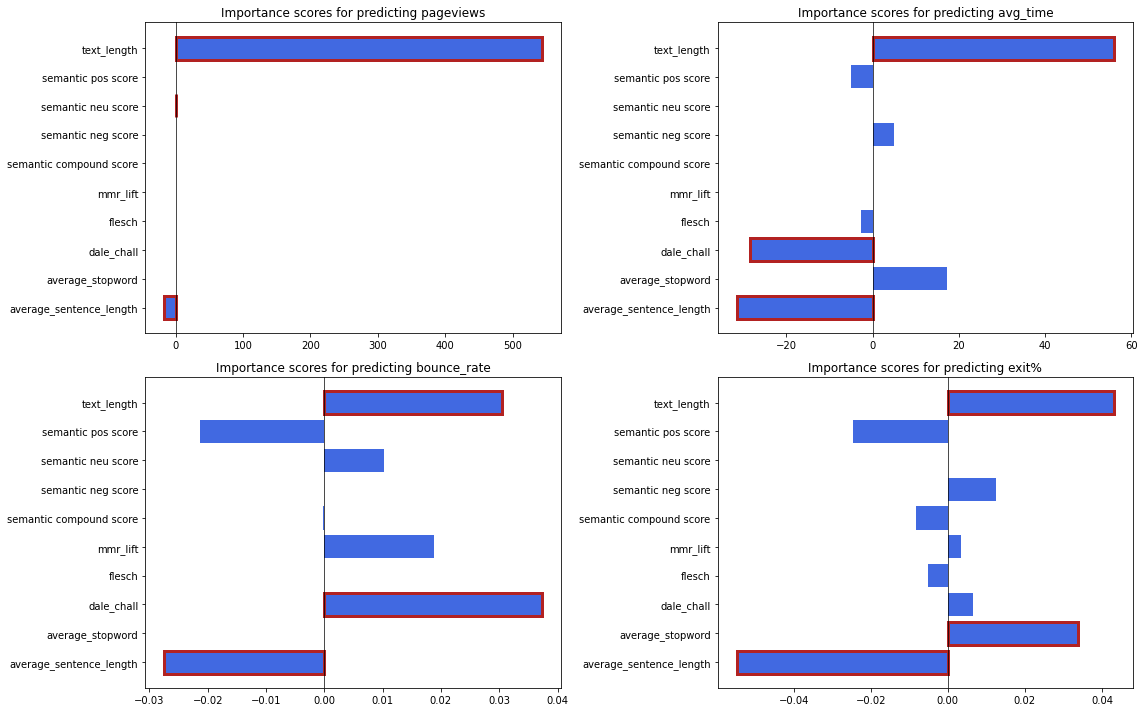

In [113]:
plt.figure(figsize=(16,10))
for i, target_feature in enumerate(performance_features):
    X = df[predictors]
    y = df[target_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    scaler = StandardScaler().fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    model = opt_models[i]
    top_features = [predictors[i] for i in np.argpartition(np.abs(model.coef_), -3)[-3:]]
    ax = plt.subplot(2,2,i+1)
    bar_colors = [3 if feat in top_features else 0 for feat in predictors]
    ax.axvline(0, color='black', lw=0.7)
    ax.barh(predictors, model.coef_, fc='royalblue', ec='firebrick', lw=bar_colors)
    ax.set_title(f'Importance scores for predicting {target_feature}')
    # ax.set_xticks(range(len(predictors)), predictors, rotation=45)
    print(f'-- Evaluating optimal Lasso model for predicting [{target_feature}]')
    print(' Top features: ', ", ".join(top_features))
    print(' RMSE: ', math.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print()
plt.tight_layout()
plt.show()
    

The linear models don't do so well with predicting the performance of the blog, which indicates that the importance scores might also be unreliable. Let's try another approach. Instead of linear regression, we can use random tree forest regressors to asses importance of the features based on the reduction in the criterion used to select split points, like Gini or entropy.

# Random Forest Regressor feature selection

-- Evaluating RFR model for predicting [pageviews]
 Top features:  mmr_lift, dale_chall, text_length
 RMSE:  2346.9969803147865

-- Evaluating RFR model for predicting [avg_time]
 Top features:  flesch, dale_chall, text_length
 RMSE:  167.53820842884124

-- Evaluating RFR model for predicting [bounce_rate]
 Top features:  semantic neu score, average_sentence_length, flesch
 RMSE:  0.22825257101772511

-- Evaluating RFR model for predicting [exit%]
 Top features:  text_length, semantic pos score, average_sentence_length
 RMSE:  0.15333708147059366



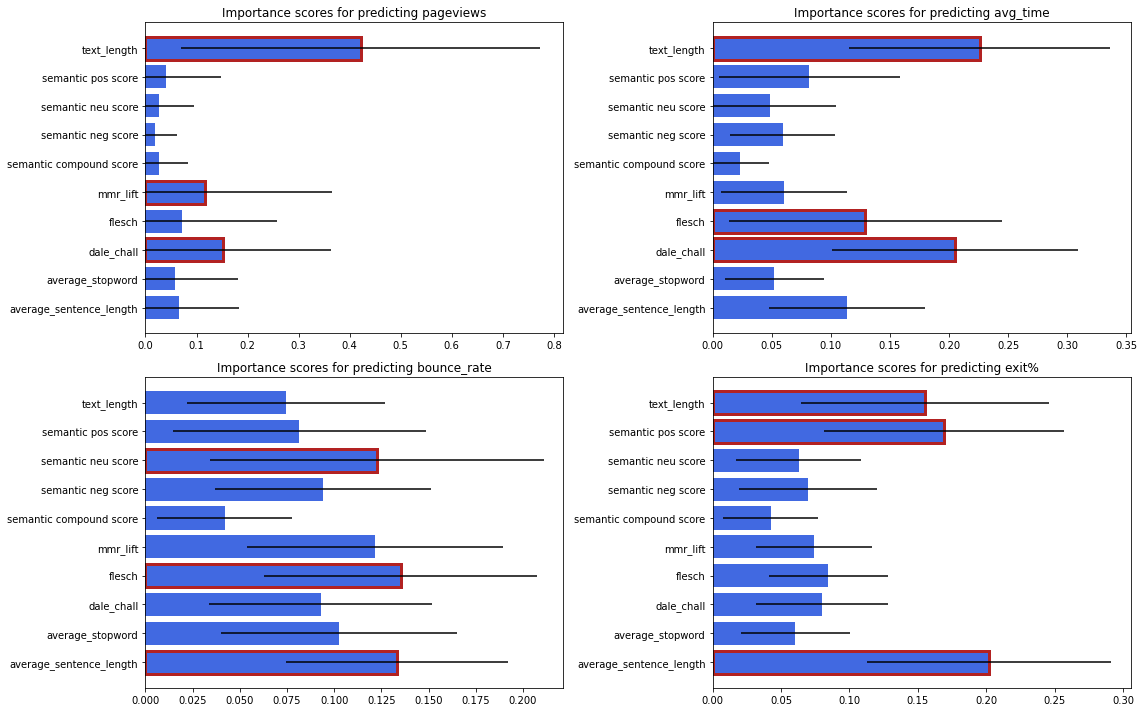

In [107]:
from sklearn.ensemble import RandomForestRegressor

plt.figure(figsize=(16,10))
for i, target_feature in enumerate(performance_features):
    X = df[predictors]
    y = df[target_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    top_features = [predictors[i] for i in np.argpartition(model.feature_importances_, -3)[-3:]]
    bar_colors = [3 if feat in top_features else 0 for feat in predictors]
    ax = plt.subplot(2,2,i+1)
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    ax.barh(predictors, np.abs(model.feature_importances_), xerr=std, fc='royalblue', ec='firebrick', lw=bar_colors)
    ax.set_title(f'Importance scores for predicting {target_feature}')
    ax.set_xlim(left=0)
    print(f'-- Evaluating RFR model for predicting [{target_feature}]')
    print(' Top features: ', ", ".join(top_features))
    print(' RMSE: ', math.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print()
plt.tight_layout()
plt.show()